# 思路
将所有的图片分成大小为256x256的patch，包括images和masks中的图片。利用这些patch训练模型。  
疑问：不是说给每个像素分类吗？为什么是对patch分类？  
答：不是给某个patch分成某个类，而是对一个patch中的每个像素进行分类。


# 数据准备

Now patchifying image: D:\Projects\VsCode\Python\img_processing_system\classification\cnn\data\Semantic segmentation dataset\Tile 1\images/image_part_001.jpg
Now patchifying image: D:\Projects\VsCode\Python\img_processing_system\classification\cnn\data\Semantic segmentation dataset\Tile 1\images/image_part_002.jpg
Now patchifying image: D:\Projects\VsCode\Python\img_processing_system\classification\cnn\data\Semantic segmentation dataset\Tile 1\images/image_part_003.jpg
Now patchifying image: D:\Projects\VsCode\Python\img_processing_system\classification\cnn\data\Semantic segmentation dataset\Tile 1\images/image_part_004.jpg
Now patchifying image: D:\Projects\VsCode\Python\img_processing_system\classification\cnn\data\Semantic segmentation dataset\Tile 1\images/image_part_005.jpg
Now patchifying image: D:\Projects\VsCode\Python\img_processing_system\classification\cnn\data\Semantic segmentation dataset\Tile 1\images/image_part_006.jpg
Now patchifying image: D:\Projects\VsCode\Python\img

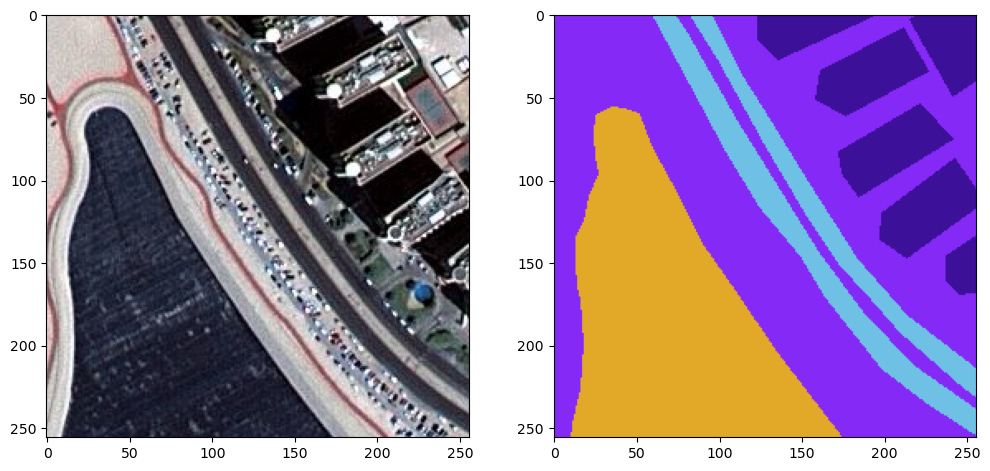

60
labels.shape =  (1305, 256, 256)
image_dataset.shape =  (1305, 256, 256, 3)
unique(labels)=  [0 1 2 3 4 5]


In [1]:
import os
import cv2
import numpy as np
import torch
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
os.environ['SM_FRAMEWORK'] = 'tf.keras'

from sklearn.preprocessing import MinMaxScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

scaler = MinMaxScaler()

root_directory = 'D:\Projects\VsCode\Python\img_processing_system\classification\cnn\data\Semantic segmentation dataset'

patch_size = 256

# Read images from repsective 'images' subdirectory
# As all images are of ddifferent size we have 2 options, either resize or crop
# But, some images are too large and some small. Resizing will change the size of real objects.
# Therefore, we will crop them to a nearest size divisible by 256 and then 
# divide all images into patches of 256x256x3. 
image_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':   #Find all 'images' directories
        images = os.listdir(path)  #List of all image names in this subdirectory
        for i, image_name in enumerate(images):  
            if image_name.endswith(".jpg"):   #Only read jpg images...
               
                image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR
                SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                image = np.array(image)             
       
                #Extract patches from each image
                print("Now patchifying image:", path+"/"+image_name)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap

                #处理每个patch
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        
                        single_patch_img = patches_img[i,j,:,:]
                        
                        #Use minmaxscaler instead of just dividing by 255. 
                        single_patch_img = scaler\
                            .fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1]))\
                            .reshape(single_patch_img.shape)
                        
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. 
                        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
                        image_dataset.append(single_patch_img)
                
  
                
  
 #Now do the same as above for masks
 #For this specific dataset we could have added masks to the above code as masks have extension png
mask_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':   #Find all 'images' directories
        masks = os.listdir(path)  #List of all image names in this subdirectory
        for i, mask_name in enumerate(masks):  
            if mask_name.endswith(".png"):   #Only read png images... (masks in this dataset)
               
                mask = cv2.imread(path+"/"+mask_name, 1)  #Read each image as Grey (or color but remember to map each color to an integer)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #mask = mask.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                mask = np.array(mask)             
       
                #Extract patches from each image
                print("Now patchifying mask:", path+"/"+mask_name)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        
                        single_patch_mask = patches_mask[i,j,:,:]
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
                        single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.                               
                        mask_dataset.append(single_patch_mask) 
 
image_dataset = np.array(image_dataset) # 所有images目录下所有图片的patch, 一共1305个patches, 每个都是256x256
mask_dataset =  np.array(mask_dataset)  # 所有images目录下所有mask的patch
print("len(image_dataset) = ", len(image_dataset))
print("len(mask_dataset) = ", len(mask_dataset))

#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))  # 随机的image_number
plt.figure(figsize=(12, 6))
plt.subplot(121)
print("image_number =", image_number)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()


###########################################################################
"""
RGB to HEX: (Hexadecimel --> base 16): 
This number divided by sixteen (integer division; ignoring any remainder) gives 
the first hexadecimal digit (between 0 and F, where the letters A to F represent 
the numbers 10 to 15). The remainder gives the second hexadecimal digit. 
0-9 --> 0-9
10-15 --> A-F

Example: RGB --> R=201, G=, B=

R = 201/16 = 12 with remainder of 9. So hex code for R is C9 (remember C=12)

Calculating RGB from HEX: #3C1098
3C = 3*16 + 12 = 60
10 = 1*16 + 0 = 16
98 = 9*16 + 8 = 152

"""
#Convert HEX to RGB array
# Try the following to understand how python handles hex values...
a=int('3C', 16)  #3C with base 16. Should return 60. 
print(a)
#Do the same for all RGB channels in each hex code to convert to RGB
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#') 
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#') 
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#') 
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#') 
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

label = single_patch_mask

# Now replace RGB to integer values to be used as labels.
#Find pixels with combination of RGB for the above defined arrays...
#if matches then replace all values in that pixel with a specific integer
def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5
    
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    
    return label_seg

# 根据mask_dataset的RGB值，将其转换为256x256，且取值范围从[0,5]的二维label矩阵
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)    

labels = np.array(labels)   

print("labels.shape = ", labels.shape) # labels.shape= (1305, 256, 256) # labels与image_dataset的shape是否要保持一致？后面没报错，应该没事。
print("image_dataset.shape = ", image_dataset.shape) # image_dataset.shape =  (1305, 256, 256, 3)
print("unique(labels)= ", np.unique(labels)) # [0 1 2 3 4 5]






"""
# 将[0,5]的二维label矩阵转为6个二维且取值为0或1的矩阵。
labels = np.expand_dims(labels, axis=3) # 增加维度

print("Unique labels in label dataset are: ", np.unique(labels))

#Another Sanity check, view few mages, 目的为了防止在转换数据的过程中，出现某些问题
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0]) # 疑问：labels中的元素取值为0-5，那么图像应该是接近黑色。
plt.show()


############################################################################


n_classes = len(np.unique(labels))
from keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes) # labels_cat.shape = (1305, 256, 256, 6)，元素值0和1
"""
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels, test_size = 0.20, random_state = 42)


# 定义模型

In [ ]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=6,                      # model output channels (number of classes in your dataset)
)

# move model to device
model.to(device)

In [15]:
print(type(model))

<class 'segmentation_models_pytorch.decoders.unet.model.Unet'>


# 误差函数和优化器

In [ ]:
import torch.nn as nn
import torch.optim as optim

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 模型训练

In [ ]:
n_epochs = 10
batch_size = 10

for epoch in range(n_epochs):
    model.train()
    latest_loss = 0.0
    for i in range(0, len(X_train), batch_size):
        batch_X = X_train[i : i+batch_size]    # batch_X shape (N, H, W, C)
        batch_y = y_train[i : i+batch_size]    # batch_y shape (N, H, W)

        # convert to torch tensors with correct shapes/dtypes:
        # inputs.shape= (N, C, H, W), dtype= float32
        inputs = torch.tensor(batch_X, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
        # targets -> (N, H, W), long (required by CrossEntropyLoss)
        targets = torch.tensor(batch_y, dtype=torch.long).to(device) # targets.shape =[10, 256, 256]
        optimizer.zero_grad()
        # 为什么outputs.shape不是 [10, 256, 256]？而是[10, 6, 256, 256]，6代表什么？我只是在定义UNet模型时，设置了classes=6
        # 答：10代表10个三维矩阵。每个三维矩阵代表：找到6个256x256的二维矩阵中每个位置处最大值所在的矩阵下标，即得到一个HxW的已分类矩阵。

        outputs = model(inputs)  # outputs shape: (N, num_classes, H, W) , outputs.shape= [10, 6, 256, 256]
        loss = loss_fn(outputs, targets) # 疑问：为什么outputs和targets的shape不一样不会报错？ChatGPT答：outputs and targets shapes are exactly what CrossEntropyLoss expects
        loss.backward()
        optimizer.step()

        latest_loss = loss.item()

    print(f'Finished epoch {epoch}, latest loss {latest_loss}')

In [ ]:
# 保存模型
torch.save(model, 'D:\Projects\VsCode\Python\img_processing_system\classification\cnn\models\my_228_training_aerial_imagery_model.pth')

# 加载模型

In [2]:
model = torch.load('D:\Projects\VsCode\Python\img_processing_system\classification\cnn\models\my_228_training_aerial_imagery_model.pth', weights_only=False)
model.eval()
model.to(device)

d:\Projects\VsCode\Python\img_processing_system\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

# 模型测试

test_img.shape=  (256, 256, 3)
input_tensor.shape = torch.Size([1, 3, 256, 256])
predicted_img unique val=  [0 1 3 4]


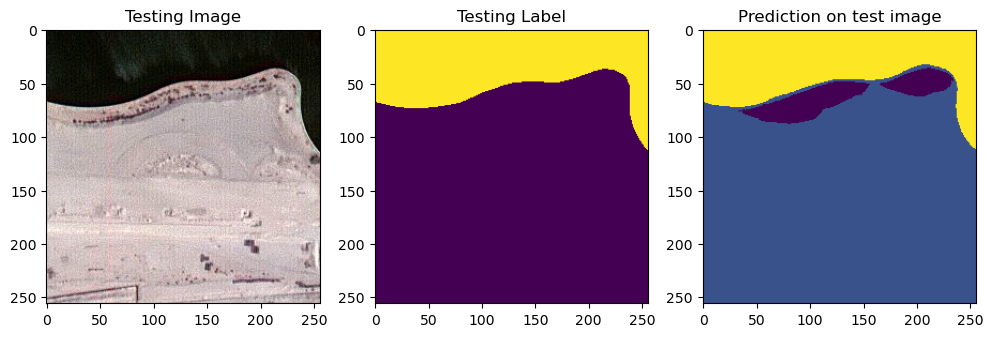

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.99      0.94      0.96     50148
           3       0.00      0.00      0.00         0
           4       1.00      0.94      0.97     15388

    accuracy                           0.94     65536
   macro avg       0.50      0.47      0.48     65536
weighted avg       0.99      0.94      0.96     65536



d:\Projects\VsCode\Python\img_processing_system\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Projects\VsCode\Python\img_processing_system\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Projects\VsCode\Python\img_processing_system\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metri

In [26]:
#Predict on a few images
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]

ground_truth = y_test[test_img_number]

# 如何把test_img交给模型来预测？
# 答：给test_img增加一个维度，然后调换维度的顺序
print("test_img.shape= ", test_img.shape) # test_img.shape=  (256, 256, 3)

# prepare input tensor: from (H, W, C) --> (1, C, H, W)
input_tensor = torch.tensor(test_img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)
print("input_tensor.shape =", input_tensor.shape)  # input_tensor.shape = (1, 3, 256, 256)

# run inference (no .predict for PyTorch modules)
model.eval()
with torch.no_grad():
	outputs = model(input_tensor)  # outputs.shape: (1, num_classes, H, W), 元素的取值：小数
	# convert logits to per-pixel class labels [0..5]
	# 这样做的原因：
	"""
		每个位置 (h,w) 对应 num_classes 个值。
		这些值 不是整数类别标签，而是 logits（还没有经过 softmax 的原始分数）。
		logit 可以是正数、小数、负数，模型会根据这些分数来表示「属于某个类别的可能性」。
	"""
	# 根据图像来看，ChatGPT说的是对的。更好的验证办法就是看论文了或者理解UNet的结构了。
	# outputs.argmax(dim=1)解释：找到num_classes个二维矩阵中每个位置处最大值所在的矩阵下标，即得到一个HxW的已分类矩阵。
	predicted_img = outputs.argmax(dim=1).squeeze(0).cpu().numpy().astype(np.uint8) 

print("predicted_img unique val= ", np.unique(predicted_img))


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

from sklearn.metrics import classification_report
print(classification_report(ground_truth.flatten(), predicted_img.flatten()))

# 评估模型
分类问题，直接用classification_report或者分类的准确率来评估即可。
求每个类别的Pixel Accuracy的平均值
Pixel Accuracy (PA, 像素精度) = 正确分类的像素数 / 总像素数    
疑问：总像素数是该图像中的所有像素吗？还是说该类别所有的像素数？
评估模型其实可以不做。